In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
household_power_consumption = pd.read_csv("household_power_consumption.txt", sep=';',
                                                parse_dates={'DateTime' : ['Date', 'Time']}, 
                                                index_col=["DateTime"],
                                                dayfirst=True,
                                                low_memory=False,
                                                na_values=['nan','?'])


In [3]:
household_power_consumption = household_power_consumption[household_power_consumption.index.year > 2006]
household_power_consumption = household_power_consumption[household_power_consumption.index.year < 2010]
household_power_consumption = household_power_consumption.fillna(method='ffill')

In [4]:
household_power_consumption = household_power_consumption["Global_active_power"]
household_power_consumption = household_power_consumption.dropna()
daily = household_power_consumption.resample("D").mean()
# daily.to_csv("daily.csv")
weekly = household_power_consumption.resample("W").mean()
# weekly.to_csv("weekly.csv")
monthly = household_power_consumption.resample("M").mean()
# monthly.to_csv("monthly.csv")
quarterly = household_power_consumption.resample("3M").mean()
# quarterly.to_csv("quarterly.csv")

[]

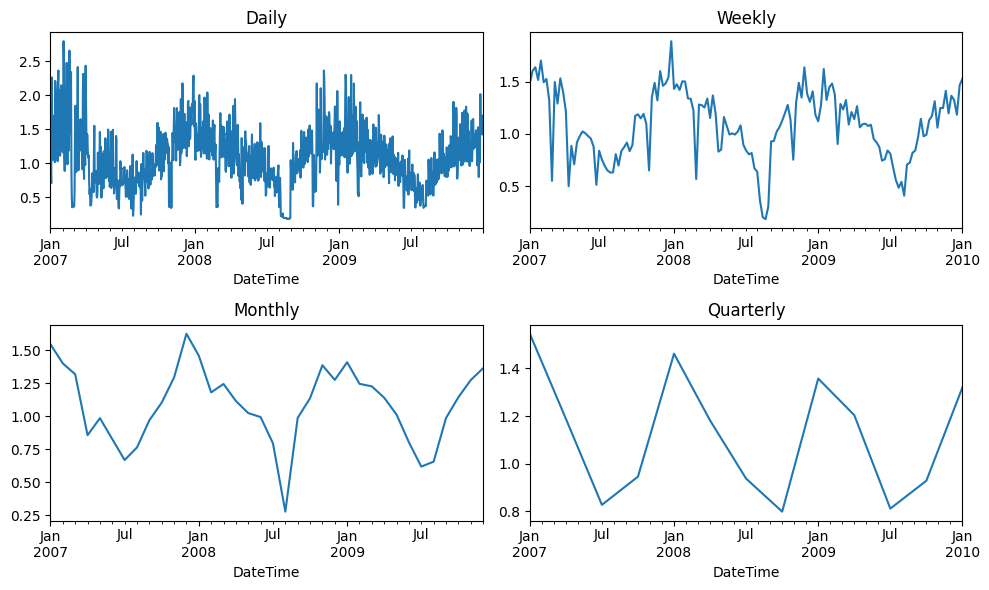

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.plot()

In [6]:
def decompose(time_period, period):
    decomposition = sm.tsa.seasonal_decompose(time_period, model='additive', period=period)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
    axes[0].plot(decomposition.trend)
    axes[0].set_title("Trend")
    axes[1].plot(decomposition.seasonal)
    axes[1].set_title("Seasonality")
    axes[2].plot(decomposition.resid)
    axes[2].set_title("Residual")
    plt.tight_layout()
    plt.plot()
    print(ADF(decomposition.resid.dropna()))
    print(PhillipsPerron(decomposition.resid.dropna()))
    return decomposition.resid.dropna()

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.322
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -20.882
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


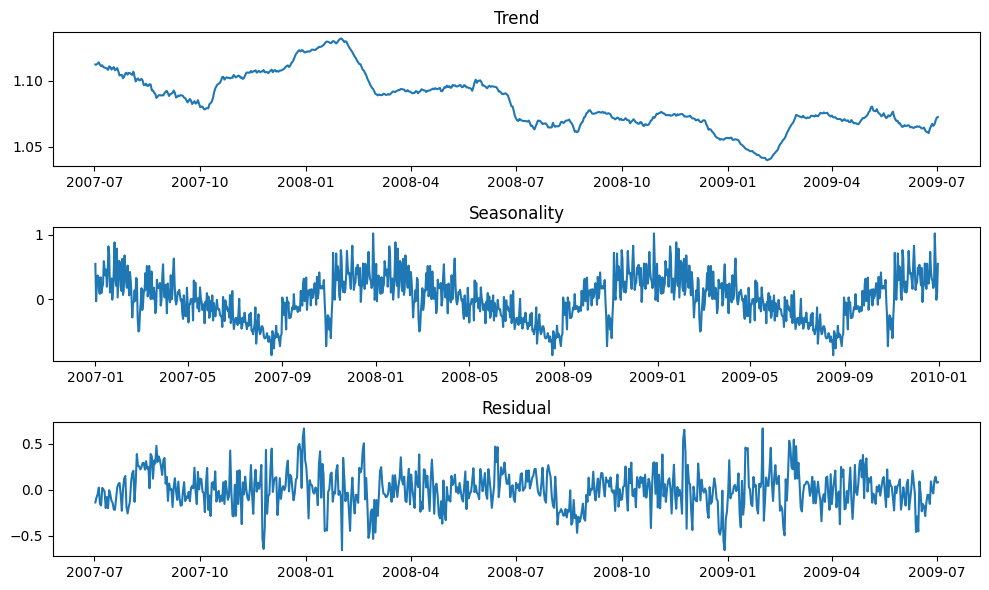

In [7]:
daily_resid     = decompose(daily, 365)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.049
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.486
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


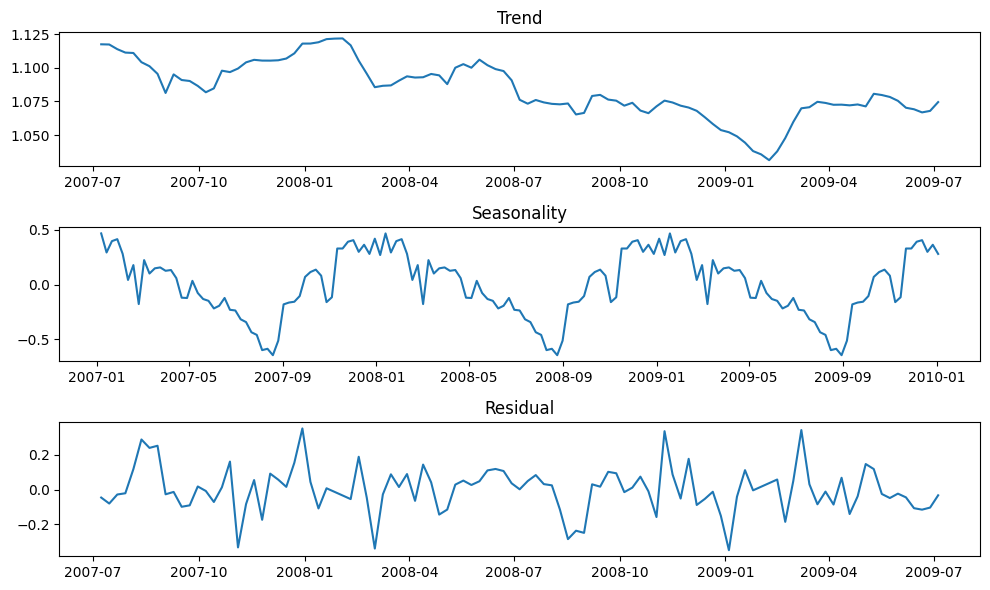

In [8]:
weekly_resid = decompose(weekly, 53)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.403
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.79 (1%), -3.01 (5%), -2.65 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.193
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.75 (1%), -3.00 (5%), -2.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


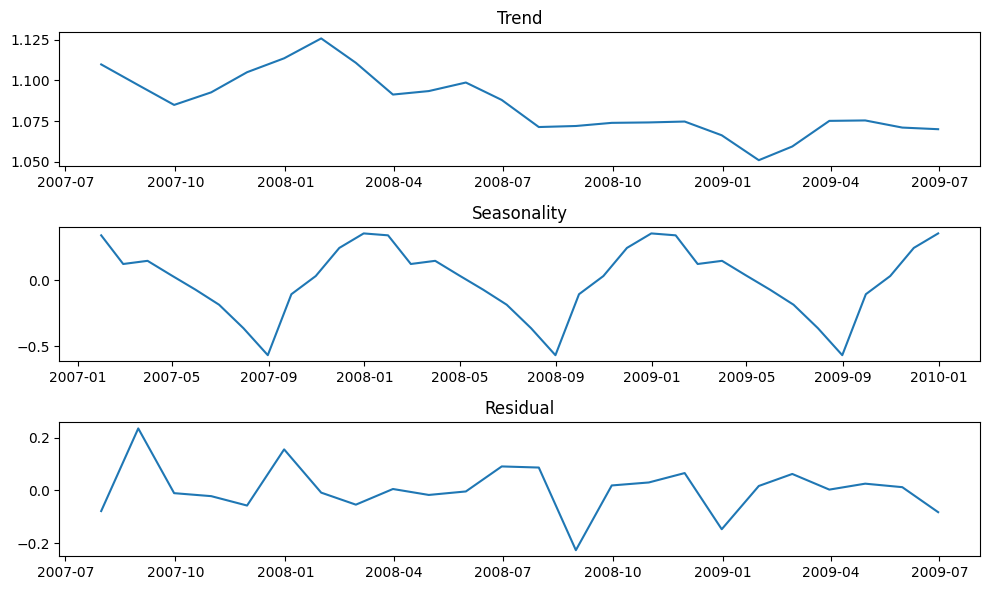

In [9]:
monthly_resid = decompose(monthly, 12)

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.990
P-value                         0.001
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -4.94 (1%), -3.48 (5%), -2.84 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.815
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -4.67 (1%), -3.37 (5%), -2.80 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


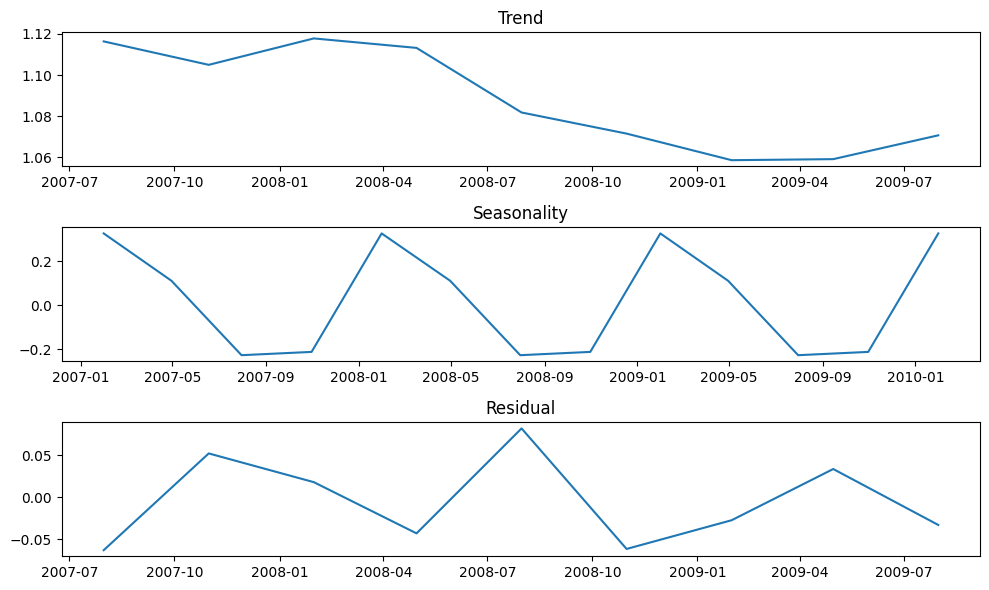

In [10]:
quarterly_resid = decompose(quarterly, 4)

In [11]:
def test_arima(timeseries):
    order_values = [(p, d, q) for p in range(4) for d in range(2) for q in range(4)]
    best_aicc = float('inf')
    best_order = None

    for p in range(4):
        for d in range(2):
            for q in range(4):
                model = ARIMA(timeseries, order=(p, d, q))
                results = model.fit()
                aicc = results.aicc
                if aicc < best_aicc:
                    best_aicc = aicc
                    best_order = (p, d, q)
        
    return best_order, best_aicc


In [12]:
print("Best daily ARIMA parameters & AICC:")
test_arima(daily_resid)

Best daily ARIMA parameters & AICC:


((3, 0, 2), -387.3298083596863)

In [13]:
model = ARIMA(daily_resid, order=(3, 1, 3)).fit()
print(model.params)
model.summary()

ar.L1    -0.941469
ar.L2    -0.630008
ar.L3     0.212895
ma.L1     0.308652
ma.L2    -0.154828
ma.L3    -0.866513
sigma2    0.035270
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  732
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 183.671
Date:                Sat, 20 May 2023   AIC                           -353.342
Time:                        22:02:32   BIC                           -321.181
Sample:                    07-02-2007   HQIC                          -340.935
                         - 07-02-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9415      0.043    -21.766      0.000      -1.026      -0.857
ar.L2         -0.6300      0.049    -12.746      0.000      -0.727      -0.533
ar.L3          0.2129      0.040      5.328      0.000       0.135       0.291
ma.L1          0.3087      0.035      8.854      0.000       0.240       0.377
ma.L2         -0.1548      0.033     -4.684      0.000      -0.220      -0.090
ma.L3         -0.8665      0.032    -27.159      0.000      -0.929      -0.804
sigma2         0.0353      0.002     21.295      0.000       0.032       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.22
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.01
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model = ARIMA(daily_resid, order=(3, 0, 2)).fit()
print(model.params)
model.summary()

const     0.000899
ar.L1     1.958258
ar.L2    -1.412769
ar.L3     0.283141
ma.L1    -1.636555
ma.L2     0.947004
sigma2    0.034568
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  732
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 200.742
Date:                Sat, 20 May 2023   AIC                           -387.485
Time:                        22:02:33   BIC                           -355.314
Sample:                    07-02-2007   HQIC                          -375.074
                         - 07-02-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.013      0.071      0.943      -0.024       0.026
ar.L1          1.9583      0.040     49.372      0.000       1.881       2.036
ar.L2         -1.4128      0.069    -20.337      0.000      -1.549      -1.277
ar.L3          0.2831      0.038      7.499      0.000       0.209       0.357
ma.L1         -1.6366      0.027    -59.804      0.000      -1.690      -1.583
ma.L2          0.9470      0.026     36.409      0.000       0.896       0.998
sigma2         0.0346      0.002     20.813      0.000       0.031       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                11.81
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.00
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
print("Best weekly ARIMA parameters & AICC:")
test_arima(weekly_resid)

Best weekly ARIMA parameters & AICC:


((2, 0, 2), -142.5294833193129)

In [16]:
print("Best monthly ARIMA parameters & AICC:")
test_arima(monthly_resid)

Best monthly ARIMA parameters & AICC:


((0, 0, 1), -45.872862372357936)

In [17]:
print("Best quarterly ARIMA parameters & AICC:")
test_arima(quarterly_resid)

Best quarterly ARIMA parameters & AICC:


((0, 0, 1), -23.900550713011807)